# Week 5 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. This week, we ask you to articulate what your sample represents in context of your final project, and draw upon methods we have developed over the last three weeks to draw reasonable and representative samples. 

This week we also pivot from our recent work on unsupervized machine learning approaches to explore how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in the two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [37]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [39]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/czd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
import gensim#For word2vec, etc
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

## ***What?*** 
<200 words

In my final project, I intend to analyze the images in Chinese poetry in three different contexts (phases): classic Chinese poetry in Tang and Song Dynasty (618-1726), contemporary Chinese poetry from 1949 to 1980 and contemporary Chinese poetry from 1980 to now. Through this study, I aim to explore how aesthetic styles and values of Chinese people changed during the process of modernization. Specifically, I will ask: 1) To what extent does the aesthetic tropism and social values of poets in contemporary China inherited from traditional aesthetics and values? 2) Whether the political environments would affect poets’ selection of images and their understanding of images and how these changes mirror changes on Chinese people’s values under different political contexts?

## ***Why?***
<200 words

Poetry, as a form of literature that evoke meanings and emotions, is carrier of the aesthetic styles and values of certain people and certain ages. Different form western poetry, one of the most remarkable characteristics of Chinese poetry is its use of images. Chinese poets uses images to convey their emotions and meanings rather than speak that loud (e.g. the image of burning candles represents marriage and love in lots of Chinese poems). Therefore, investigating in images in Chinese poetry provides us a window to look into the deep aesthetic orientation and cultural values of Chinese people. The change on the using of images can reveal how values change over time. Although there are numerous Chinese researches focus on images of Chinese poetry, seldom of them use a large-scale content analysis approach to picture the trajectory of image changes, which is the starting point of my study.


## ***How?***
<400 words

In order to answer my research question and to reveal the underlying imprint cultural and social games, I will investigate in images in Chinese poetry in different phases through following approaches:

1)	Analyze word frequencies and collocations to see what images were widely used in Chinese poetry? What images have been consistently used in all the phases? What images that widely used in classical Chinese poetry were discarded in contemporary poetry? If there any new images are created and applied in contemporary poetry? If there any patterns of image collocation and how these patterns changed over time?

2)	Analyze the meaning of images using word-embedding approach. By analyzing how images embedded in their local linguistic contexts and what’s the semantic relationship between words, I intend to learn about the meaning of certain images and the underlying discursive culture. Whether and how an image’s meaning changed in different phases? How these changes reveal the flowing of value in different contexts?

3)	Analyze sentiments of images using sentimental analysis. Poets’ sentiments toward certain images are also an important indicator that can show what aesthetic and value pursuit is behind the uses of images. What are the most positive and negative images in different phases? Whether the sentiment of certain images changed over time? 


## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

## ***Which (words)?***
<300 words

For classical Chinese poetry, I will use the corpuses of “Three Hundred Tang Poems” and “Three Hundred Song Poems”, so it’s going to be 600 poems from Tang Dynasty and Song Dynasty in total. Tang and Song are considered as the peak and the most representative periods of classical Chinese poetry. These two sample sets were firstly selected by scholars in Qing Dynasty, containing the most representative and famous poems in these two dynasty. And they were widely used as the initiatory teaching material to Chinese people. 

For contemporary Chinese poetry, I scraped poems from the website “Chinese poetry corpus (Zhonghua Shiku)” as my corpus, which contains all 8744 poems of 613 contemporary poets. And I will divide this corpus into two corpuses based on the time period I have mentioned above.

Limitations of my sample includes: 1) the sample size of classical corpus is smaller than the contemporary ones and 2) the sample selection of contemporary corpus is based on poetry experts and lovers who works for the source website, the specific selecting criteria remains unclear. 

Possible “scale-up” for further analysis: 1) increase sample size for classical corpus by using corpus like “Full Tang Poems (Quan Tang Shi)” which contains more than 40,000 poems in Tang dynasty, 2) includes poems from dynasties other than Tang and Song, to cover poetry in all phases of ancient China, and 3) use corpus with a larger sample size of contemporary poems, or some corpus with a clear and convincing sampling.


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, demonstrate three approaches drawn from any of the last three weeks to create subsamples of your corpus (e.g., for crowd-sourced subcoding like we'll be doing this week). Methods of subsampling include (a) corpus linguistic approaches drawing on word presence or co-presence, conditional frequencies, weighted words (e.g., tf.idf), KL or JS divergences, etc.; (b) hierarchical or flat clustering approaches; (c) topic modeling; or (d) word-embedding. (<200 words).

### Import Data

In [36]:
trumpDF = pandas.read_csv("../data/trump100days.csv")

In [40]:
#Apply our functions, notice each row is a list of lists now
trumpDF['tokenized_sents'] = trumpDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
trumpDF['normalized_sents'] = trumpDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

trumpDF[:5]

,text,tokenized_sents,normalized_sents
0,RT @jmichaelkell: To sum it up:\r\r1. Trump - ...,"[[RT, @, jmichaelkell, :, To, sum, it, up, :, ...","[[rt, jmichaelkell, sum], [trump, sexual, pred..."
1,RT @DrDavidDuke: Did John McCain wiretap Presi...,"[[RT, @, DrDavidDuke, :, Did, John, McCain, wi...","[[rt, drdavidduke, john, mccain, wiretap, pres..."
2,RT @PrisonPlanet: The Revolutionary Communist ...,"[[RT, @, PrisonPlanet, :, The, Revolutionary, ...","[[rt, prisonplanet, revolutionary, communist, ..."
3,"""Team Trump shares tips on keeping their boss ...","[[``, Team, Trump, shares, tips, on, keeping, ...","[[team, trump, shares, tips, keeping, boss, di..."
4,RT @larryelder: Rep. @MaxineWaters says Trump'...,"[[RT, @, larryelder, :, Rep., @, MaxineWaters,...","[[rt, larryelder, maxinewaters, says, trump, c..."


### Corpus linguistic approach - word frequencies

In [46]:
numWords = 100
targetWords =trumpW2V.wv.index2word[:numWords]

In [47]:
targetWords[:10]

['trump',
 'rt',
 'https',
 'president',
 'donald',
 'amp',
 'obama',
 'via',
 'us',
 'like']

### Word-embedding method

In [43]:
trumpW2V = gensim.models.word2vec.Word2Vec(trumpDF['normalized_sents'].sum())

Randomly partitions the corpus into non-overlapping samples, then estimates the word-embedding models on these subsets.

In [51]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [55]:
n_samples = 10
sample_indices = np.random.randint(0,n_samples,(len(trumpDF),))

s_k =np.array([])
tau_k=np.array([])

for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(trumpDF[sample_indices == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, cos_difference(sample_w2v, 'america', 'greater')[0,0])
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(trumpDF[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

/Users/czd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


[0.95404112 0.95183426 0.96141446 0.95368278 0.94558525 0.9476285
 0.93924242 0.96935993 0.94972014 0.92941201]
[24232. 24605. 24480. 24622. 24402. 24550. 24508. 24301. 24542. 24561.]


### Corpus linguistic approach - word frequencies

In [49]:
numWords = 100
targetWords =trumpW2V.wv.index2word[:numWords]

In [50]:
targetWords[:10]

['trump',
 'rt',
 'https',
 'president',
 'donald',
 'amp',
 'obama',
 'via',
 'us',
 'like']

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [125]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [126]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [127]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [128]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [129]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


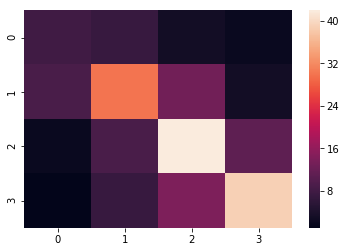

In [130]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [131]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [132]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [133]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [134]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [135]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


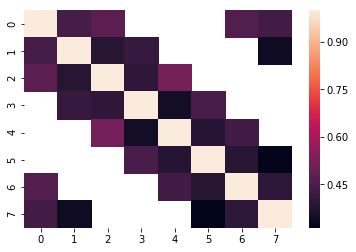

In [136]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [137]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [138]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [139]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

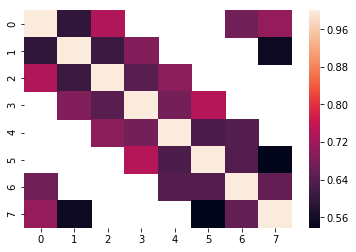

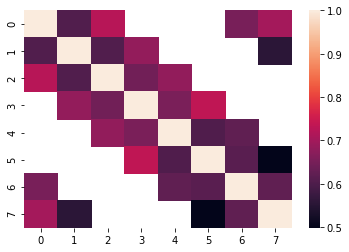

In [140]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [141]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <span style="color:red">*Excercise 2*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides on this week's Canvas page.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In exercise 1, we got a subsample set containing 100 most frequent words from Trump's tweets. I performed a content sentimental analysis on MTurk and recruited 3 people to evaluate and code each piece of content into sentiments ([Strongly negative, negative, neutral, positive, strongly positive][1-5]).

### Annotation Data

In [101]:
csv = np.genfromtxt('../data/batch_result.csv', delimiter= ",")

In [102]:
anno = AnnotationsContainer.from_array(csv, missing_values=[-1])

In [103]:
anno.annotations

array([[1, 2, 2],
       [1, 0, 1],
       [2, 1, 2],
       [2, 2, 3],
       [2, 2, 1],
       [4, 1, 1],
       [1, 1, 2],
       [2, 2, 1],
       [1, 3, 1],
       [2, 2, 1],
       [1, 1, 2],
       [3, 2, 3],
       [1, 3, 1],
       [1, 1, 1],
       [2, 1, 0],
       [2, 2, 3],
       [0, 1, 0],
       [1, 2, 1],
       [2, 3, 2],
       [4, 4, 4],
       [1, 1, 1],
       [1, 2, 2],
       [0, 0, 1],
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 2],
       [1, 2, 2],
       [1, 2, 2],
       [1, 2, 2],
       [2, 1, 2],
       [1, 0, 0],
       [1, 1, 0],
       [3, 2, 2],
       [4, 3, 2],
       [1, 1, 1],
       [2, 1, 3],
       [1, 2, 1],
       [3, 2, 3],
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 3],
       [3, 2, 2],
       [3, 3, 2],
       [2, 2, 4],
       [2, 2, 2],
       [2, 2, 2],
       [1, 1, 3],
       [1, 1, 3],
       [0, 3, 2],
       [2, 2, 2],
       [1, 2, 2],
       [2, 4, 2],
       [0, 1, 2],
       [2, 2, 1],
       [4, 2, 1],
       [1,

In [104]:
anno.labels

[1.0, 2.0, 3.0, 4.0, 5.0]

### Interrogate Resulting Data

In [105]:
pyanno.measures.agreement.labels_frequency(anno.annotations,5)

array([0.06      , 0.32666667, 0.46666667, 0.12      , 0.02666667])

[[ 2.  2.  0.  1.  0.]
 [ 3. 20. 11.  3.  0.]
 [ 1.  9. 30.  2.  1.]
 [ 0.  1.  7.  3.  0.]
 [ 0.  1.  1.  1.  1.]]


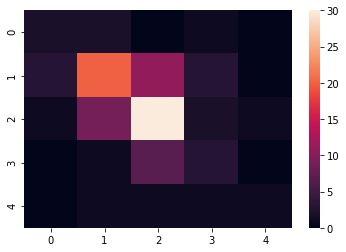

In [106]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],5)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Coders show most agreement on the sentiment of neutral, then negative. The agreement on positive is less than negative, while strong sentiments shows least agreement.

In [107]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.3240648283278286

In [108]:
fleiss_kappa(anno.annotations[::])

0.18290702395452704

In [109]:
krippendorffs_alpha(anno.annotations[::])

0.36664295874822195

In [112]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.32556713672593507

Above all, scotts_pi, fleiss_kappa, k_alpha and cohen_kappa show the agreement between coders. Their values are generally at the same level, which yield an approximately 3/10 agreement when coding.

In [113]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.32556714 0.16317992]
 [0.32556714 1.         0.06556373]
 [0.16317992 0.06556373 1.        ]]


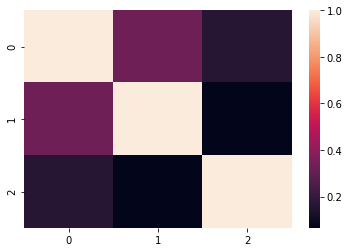

In [114]:
ax = seaborn.heatmap(m)
plt.show()

Here is coders' pairwise comparisons.It seems like their agreement with each other is pretty low. However, coder0 and coder1 share more similar answers whereas the other pair do less. So it is possible that code 2 did a worse job here.

In [120]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.18477025951137427

In [121]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.3741465634956759

Krippendorffs_alpha and cohens_weighted_kappa above which indicate the seriousness of the disagreement between each score. While the precise value is 0.18, the weighted value is 0.37, which shows more seriousness of the disagreement.

Or averaged over the total

In [122]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.2670667074790298

We can assess not agreement, but rather the correlation of values (Pearson's  ρρ ) or correlation of ranks (Spearman's  ρρ ) for pairs of coders

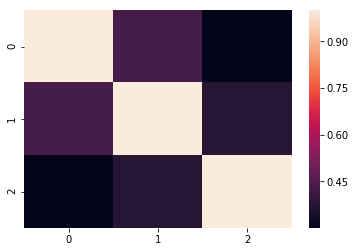

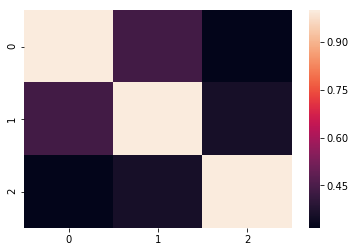

In [118]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

No matter assessing correlation of values or correlation of ranks, the results are similar to what we assessed the agreement that coders were not very correlated with each other on values or ranks. However, coder0 and coder1 are more similar compare to coder2. 

Or we can averaged over all comparable pairs

In [119]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.36779207529874447 0.36890839662857977


In conclusion, based on statistical interrogation and visualization, all my three coders share pretty low agreements with each other when coding. This is possibly due to the subjectivity of people's judgement towards certain words' sentiments. To improve the reliability of sentimental analysis coding, perhaps more evaluators are needed. 

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides two relevant models: ModelB and ModelBt. Model B with $\theta$s models the relationship between each coder and code. Model B is a Bayesian generalization of the Dawid & Skene model from the reading. The following image schematically describes these models. <img src="../data/pyanno/Bmodel.png">

The models should provide very similar results. To estimate the parameters for any models, we first need to create a new model. 

In [142]:
# create a new instance of model B, with 4 label classes
model = ModelB.create_initial_state(4,8)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.74231745 0.13598501 0.08942896 0.03226859]
  [0.06772826 0.55123749 0.35103906 0.0299952 ]
  [0.13238518 0.08134717 0.38934513 0.39692252]
  [0.05532223 0.06255522 0.09021244 0.79191011]]

 [[0.79573734 0.09332602 0.07143019 0.03950646]
  [0.1806849  0.66186872 0.08272848 0.0747179 ]
  [0.02946717 0.06936002 0.79924685 0.10192597]
  [0.00147092 0.06478717 0.06842288 0.86531904]]

 [[0.7444494  0.18124316 0.07231916 0.00198828]
  [0.20569982 0.63134642 0.13560617 0.02734759]
  [0.04561447 0.16323878 0.69867644 0.09247031]
  [0.02945244 0.04016692 0.09703125 0.83334939]]

 [[0.89286334 0.07334597 0.02623683 0.00755386]
  [0.11288191 0.58954964 0.21975661 0.07781185]
  [0.08515688 0.20492591 0.5429133  0.16700392]
  [0.0054459  0.03882772 0.33648754 0.61923883]]

 [[0.55667326 0.34167486 0.01678407 0.08486781]
  [0.15534221 0.69417732 0.11076656 0.03971391]
  [0.10821563 0.16089135 0.61207533 0.11881769]
  [0.05193494 0.06371806 0.05959942 0.82474758]]

 [[0.81415253 0.1196852  0.053

Now we train the model on our data. Pyanno allows one to use either MAP (maximum a posteriori estimation) or MLE (maximum likelihood estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator-annotation pair. First we will train with MAP, and then you can optionally training with MLE.

In [143]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [145]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

Uncomment the cell below if you would rather train by MLE.

In [146]:
#model = ModelB.create_initial_state(4,8)
#model.mle(anno.annotations)
#print(model.theta)
#print(model.log_likelihood(anno.annotations))

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [147]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[1.20741380e-42 1.00240780e-01 7.90821679e-01 1.08937540e-01]
 [9.92682453e-01 7.07056554e-03 2.46981317e-04 2.03944498e-49]
 [1.07420297e-03 5.51435353e-02 9.37476514e-01 6.30574822e-03]
 ...
 [8.15378491e-04 3.51193436e-02 9.59859130e-01 4.20614824e-03]
 [1.34481992e-44 2.14447325e-03 9.16166870e-01 8.16886569e-02]
 [2.14745550e-01 7.69057353e-01 1.61970966e-02 2.01807019e-26]]


Let's turn the posterior of the first 100 samples into a heatmap and compare with the raw vote tallies.

In [148]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<matplotlib.figure.Figure at 0x14dec0fd0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x14e1964a8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x14e782470>))

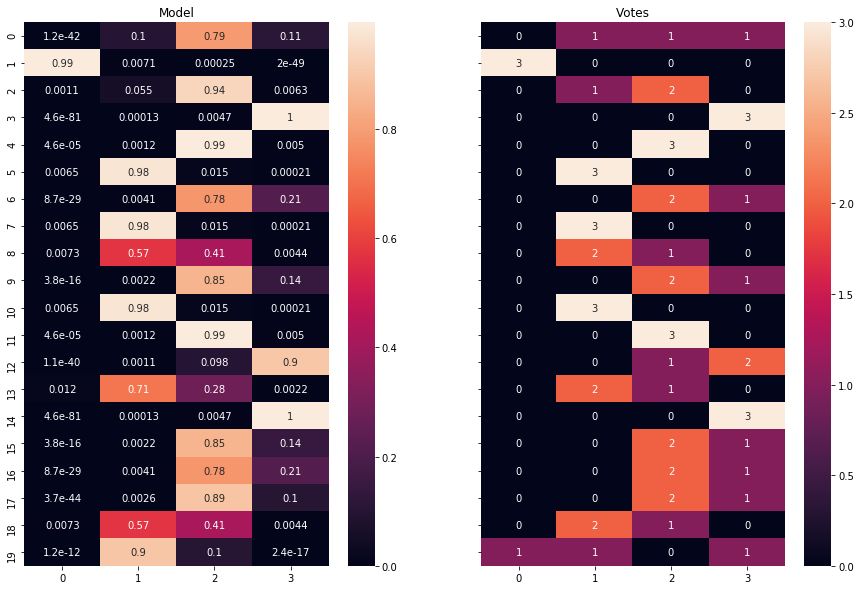

In [149]:
makeQuestionComparison(model, anno)

This differs markedly from taking annotator scores at face value. As you can see (the model-based probabilities are on left; the raw votes on right), the models helps us break ties between coders and in some cases dramatically downgrades the estimates from particularly bad coders.

Let's try everything again with ModelBt, which constrains ModelB so that each coder has a single estimate over the accuracy of all of their codes.

In [150]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.71131187 0.62818593 0.82735182 0.82021431 0.94339802 0.70523904
 0.86466111 0.67499431]
-2995.357611444207


In [151]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.79134364 0.74074267 0.76235178 0.7252461  0.7163988  0.71856382
 0.77315252 0.71666798]
-2811.9463364473904


In [152]:
model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

array([[0.76623859, 0.74712322, 0.78546912, ..., 0.71435881, 0.84860678,
        0.66359897],
       [0.76623859, 0.74712322, 0.78546912, ..., 0.71435881, 0.84860678,
        0.66359897],
       [0.76623859, 0.74712322, 0.78546912, ..., 0.71435881, 0.84860678,
        0.66359897],
       ...,
       [0.7209499 , 0.69080025, 0.78719447, ..., 0.71548547, 0.79349806,
        0.75799837],
       [0.74746329, 0.71654202, 0.77889501, ..., 0.73157064, 0.76716178,
        0.73643234],
       [0.74746329, 0.71654202, 0.77889501, ..., 0.73157064, 0.76716178,
        0.73643234]])

In [153]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.01110129 0.28932678 0.36489883 0.33467311]
 [0.99023208 0.00241681 0.00404598 0.00330512]
 [0.00249899 0.05508925 0.93458342 0.00782834]
 ...
 [0.00252845 0.04394993 0.94560099 0.00792062]
 [0.00249348 0.00571171 0.93252217 0.05927264]
 [0.03189021 0.93882893 0.01611592 0.01316494]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

(<matplotlib.figure.Figure at 0x14dfaf6d8>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x14e2b6e10>,
  <matplotlib.axes._subplots.AxesSubplot at 0x14eed1a58>))

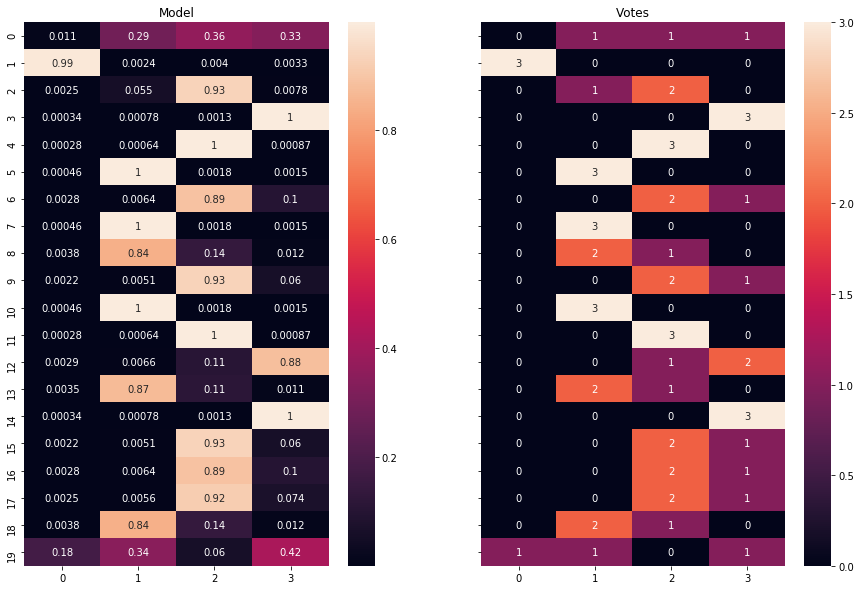

In [154]:
makeQuestionComparison(model, anno)

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. We may also use the posterior themselves rather than the most probably code outcome.

## Visualizing coder accuracy

Let's make a plot of the accuracy for each annotator inferred from ModelBt. This might be helpful if you wanted to ban a "troll" from your crowdsourcing enterprise. The coder a very low accuracy likelihood is an outlier and should be "dropped from the team."

In [155]:
model = ModelBt.create_initial_state(4,8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

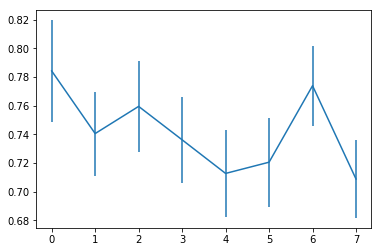

In [156]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Hotel Reviews

If we want to do a simpler analysis we can look at a different data set, here are some hotel reviews from [expedia](https://www.kaggle.com/c/expedia-hotel-recommendations)

In [9]:
df_hotels = pandas.read_csv('../data/hot_Reviews.csv', index_col=0)
df_hotels[:5]

,Karen,Scott,Jessica,write a review,A verified traveler,Kevin,William,R,S,Christopher,...,Thomas,Susan,A Traveler,M,Not Provided,B,Laura,xxxxxxxxxxxxxx,Michael,Joseph
1785 Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900 House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bed & Breakfast In Cambridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Swallow's Nest Motel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abbeville Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here a rank of 0 is a missing value and to simplify things more we will convert from a 1-10 scale to a 1-5 scale, with 0 as missing

In [10]:
df_hotels = df_hotels.apply(lambda x: x // 2) #integer divide by 2 rounds all values

And we can visualize all the reviews as a heatmap with the missing values greyed out

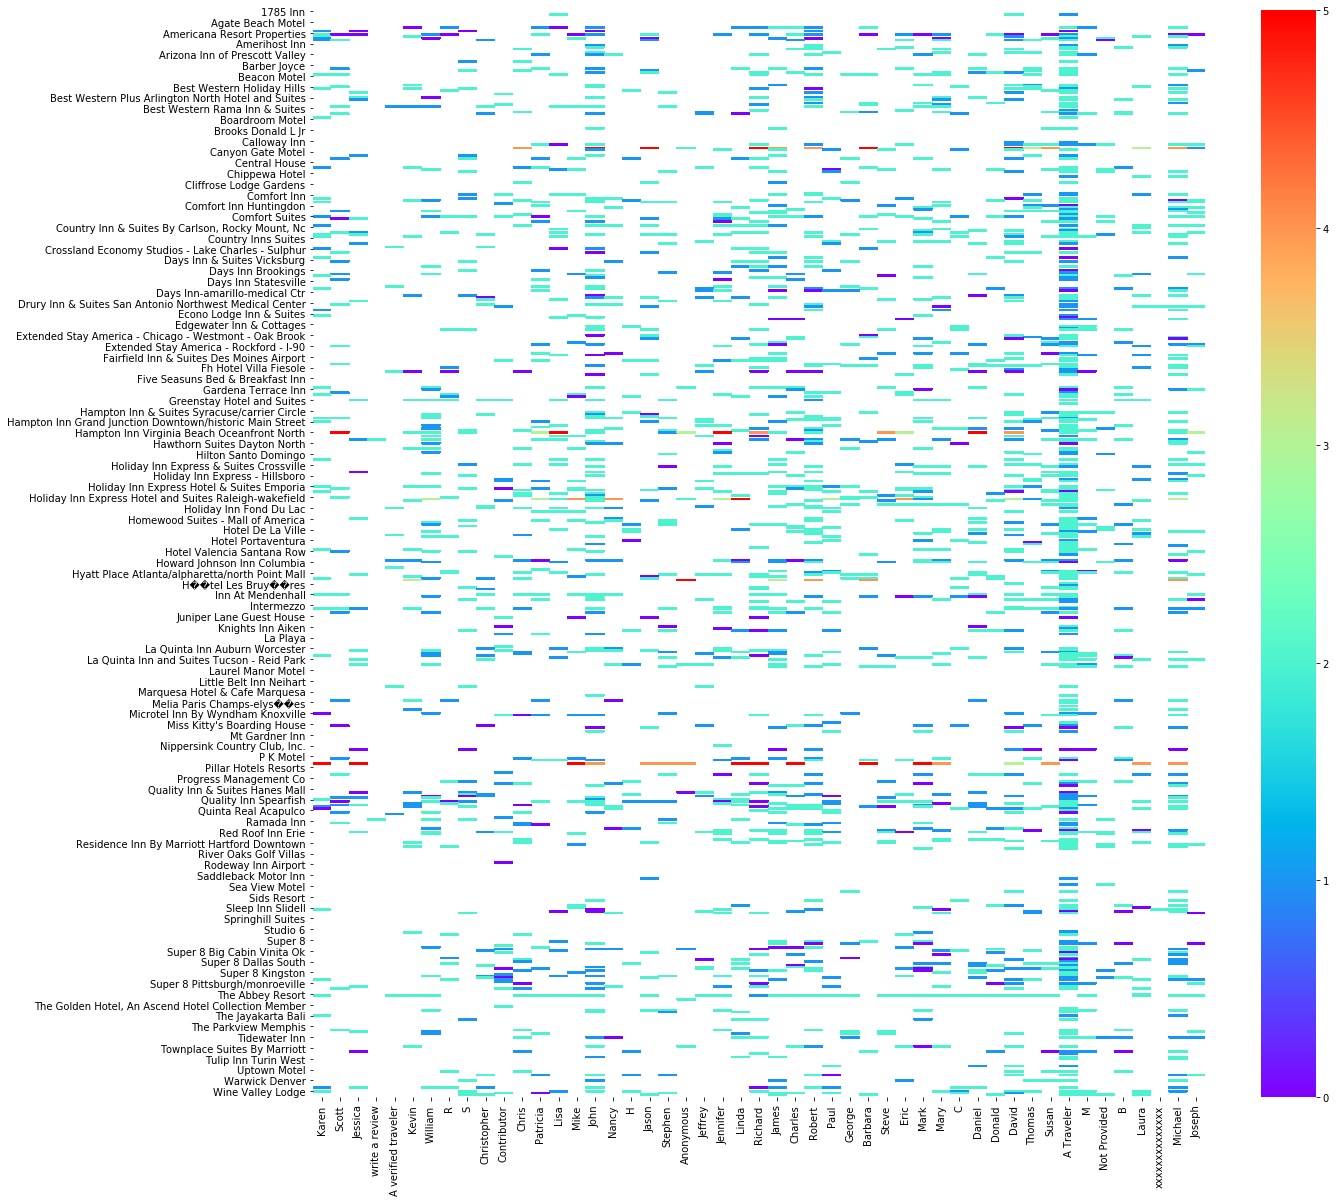

In [11]:
fig, ax = plt.subplots(figsize = (20,20))
seaborn.heatmap(df_hotels, cmap='rainbow', ax = ax)
plt.show()

To give the dataframe to pyanno we need to convert to np array and change the nans to intergers, lets use -1

In [12]:
hot_mat = np.array(df_hotels.fillna(-1).as_matrix())
anno_hot = AnnotationsContainer.from_array(hot_mat, missing_values=[-1])

In [13]:
anno_hot.annotations

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [14]:
anno_hot.labels

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [15]:
anno_hot.missing_values

[-1]

Look at coder agreement

In [ ]:
pyanno.measures.agreement.labels_frequency(anno_hot.annotations, 6)#6 possible catagories

In [ ]:
c = pyanno.measures.agreement.confusion_matrix(anno_hot.annotations[:,0], anno_hot.annotations[:,1], 6) #6 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 2 i.e. an average hotel and there's little agreement as rating go higher, likely due to scarcity in the sample

In [ ]:
scotts_pi(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

In [ ]:
krippendorffs_alpha(anno_hot.annotations[::])

In [ ]:
cohens_kappa(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

In [ ]:
m = pairwise_matrix(cohens_kappa, anno_hot.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)

And to look at what model Bt thinkgs the correct reviews are:

In [ ]:
model_hot = ModelBt.create_initial_state(6, 49)
model_hot.mle(anno_hot.annotations)
#print(model.theta)
print(model_hot.log_likelihood(anno_hot.annotations))

In [ ]:
makeQuestionComparison(model_hot, anno_hot)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MLE or MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

Create a new model

In [56]:
# create a new instance of model B, with 4 label classes
model = ModelB.create_initial_state(5,3)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.65473139 0.11009561 0.17204301 0.02092146 0.04220852]
  [0.1613581  0.54434139 0.11971578 0.12564345 0.04894128]
  [0.02471037 0.17960255 0.55675246 0.11206178 0.12687284]
  [0.02347735 0.22958148 0.1148888  0.57212109 0.05993128]
  [0.10847133 0.01139035 0.04983297 0.14116797 0.68913738]]

 [[0.605388   0.23442882 0.10694025 0.01286278 0.04038015]
  [0.14871524 0.68873488 0.08912933 0.03252148 0.04089907]
  [0.12443738 0.10640619 0.59635598 0.11234415 0.06045629]
  [0.00134866 0.08716696 0.12922    0.64360945 0.13865493]
  [0.01464128 0.02617633 0.11418887 0.1129084  0.73208512]]

 [[0.64081647 0.14110614 0.16482921 0.04343195 0.00981623]
  [0.21787626 0.51952851 0.156558   0.05709624 0.04894099]
  [0.17058812 0.08679203 0.51246846 0.19339517 0.03675622]
  [0.00456275 0.07155894 0.25855327 0.52682575 0.13849928]
  [0.01536383 0.00106739 0.08035485 0.1727514  0.73046254]]]
-453.3769745813053


Train the model on our data. First, I will train with MAP (maximum a posteriori estimation). 

In [57]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [58]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.89472380e-001 1.57896436e-001 5.26311846e-002 0.00000000e+000
   5.71742508e-301]
  [1.20693014e-001 6.88863448e-001 1.48782214e-001 2.35578120e-002
   1.81035131e-002]
  [2.15403435e-002 1.65969259e-001 6.17373027e-001 1.60932360e-001
   3.41850107e-002]
  [0.00000000e+000 4.54545455e-002 1.36363636e-001 6.81818182e-001
   1.36363636e-001]
  [1.89860193e-216 4.14202362e-269 5.02847916e-002 1.49964382e-001
   7.99750826e-001]]

 [[7.89472006e-001 1.57897647e-001 5.26303465e-002 2.30432501e-262
   0.00000000e+000]
  [1.46793911e-001 6.81243489e-001 1.10712917e-001 6.12496825e-002
   1.91645303e-121]
  [1.49944744e-002 1.23974210e-001 7.15241562e-001 1.22129288e-001
   2.36604666e-002]
  [0.00000000e+000 4.54545455e-002 1.36363636e-001 6.81818182e-001
   1.36363636e-001]
  [0.00000000e+000 2.70204067e-250 5.02562620e-002 1.51693957e-001
   7.98049781e-001]]

 [[7.89464844e-001 1.57899115e-001 5.26360407e-002 0.00000000e+000
   0.00000000e+000]
  [1.64317441e-001 5.57452231e-001 2.31

/Users/czd/anaconda3/lib/python3.6/site-packages/pyanno/util.py:80: RuntimeWarning: divide by zero encountered in log
  log_theta = ninf_to_num(log(theta))


Now we can make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [59]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[3.99864610e-008 1.28247230e-001 8.71752730e-001 7.46078509e-021
  2.20806867e-272]
 [4.35240924e-006 9.89118188e-001 1.08774599e-002 0.00000000e+000
  0.00000000e+000]
 [5.45894655e-008 2.32678131e-001 7.67321814e-001 1.01852140e-020
  1.96754187e-253]
 [0.00000000e+000 5.46526128e-003 9.94458871e-001 1.10274132e-019
  7.58676456e-005]
 [4.62497891e-008 7.70488279e-002 9.22951126e-001 8.63006402e-021
  1.99539426e-158]
 [2.26509456e-305 8.66885553e-001 1.33114447e-001 4.32287400e-020
  0.00000000e+000]
 [1.27589252e-007 8.39293308e-001 1.60706565e-001 2.64499570e-021
  0.00000000e+000]
 [4.62497891e-008 7.70488279e-002 9.22951126e-001 8.63006402e-021
  1.99539426e-158]
 [2.53416157e-267 8.23268629e-001 1.76731371e-001 5.99999136e-020
  0.00000000e+000]
 [4.62497891e-008 7.70488279e-002 9.22951126e-001 8.63006402e-021
  1.99539426e-158]
 [1.27589252e-007 8.39293308e-001 1.60706565e-001 2.64499570e-021
  0.00000000e+000]
 [0.00000000e+000 3.32420139e-003 9.95806637e-001 2.11804953e-018

Turn the posterior of the first half samples into a heatmap and compare with the raw vote tallies.

In [60]:
def makeQuestionComparison(model, anno_target, num_questions = 50):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<matplotlib.figure.Figure at 0x14b030390>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x14b030518>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1222ed5f8>))

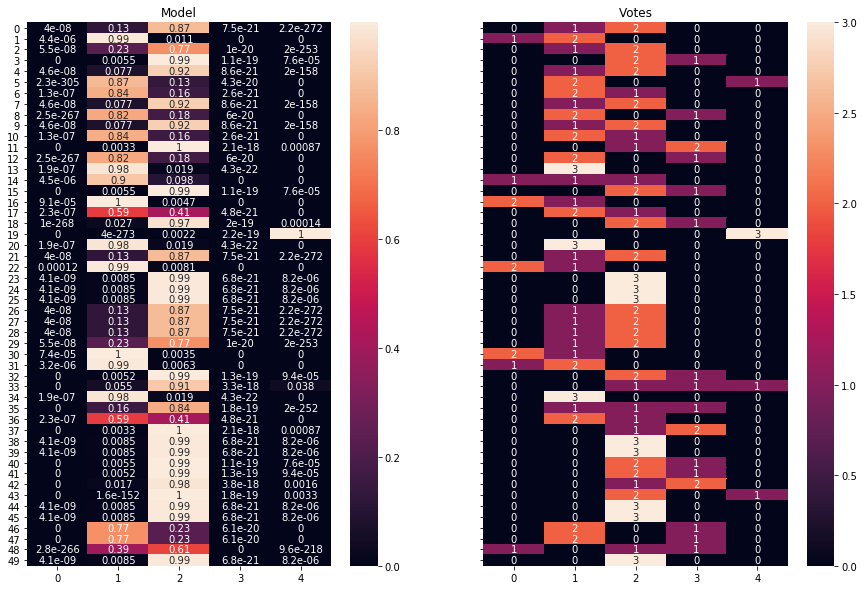

In [61]:
makeQuestionComparison(model, anno)

The model-based probabilities on the left help us to break ties btween coder. Overall, the model shows more neutral sentiments than the row vote.

Let's try everything again with ModelBt, which constrains ModelB so that each coder has a single estimate over the accuracy of all of their codes.

In [62]:
model = ModelBt.create_initial_state(5, 3)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.72478868 0.90343563 0.67128327]
-433.05327144722355


In [63]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.68947123 0.72184719 0.5823184 ]
-381.5463395339593


In [64]:
model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

array([[0.63286929, 0.69605454, 0.60800239],
       [0.63955666, 0.69799908, 0.5862807 ],
       [0.63955666, 0.69799908, 0.5862807 ],
       [0.63955666, 0.69799908, 0.5862807 ],
       [0.69215248, 0.72960499, 0.59522507],
       [0.64717697, 0.63033883, 0.64168904],
       [0.64717697, 0.63033883, 0.64168904],
       [0.56860198, 0.64065017, 0.60355921],
       [0.55825067, 0.64075939, 0.63194545],
       [0.55825067, 0.64075939, 0.63194545],
       [0.60346568, 0.67850038, 0.61459932],
       [0.62320223, 0.68501632, 0.51627382],
       [0.62320223, 0.68501632, 0.51627382],
       [0.64261361, 0.6824978 , 0.57567851],
       [0.71017177, 0.75422851, 0.5666627 ],
       [0.70016355, 0.65419085, 0.56611081],
       [0.71700304, 0.59859567, 0.52824614],
       [0.74727357, 0.68032999, 0.47690411],
       [0.76605819, 0.66658933, 0.48516835],
       [0.73538964, 0.65836047, 0.53653516],
       [0.73538964, 0.65836047, 0.53653516],
       [0.73276875, 0.69931523, 0.60359324],
       [0.

In [65]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[1.02340588e-08 8.35776873e-02 9.15776203e-01 4.11363054e-04
  2.34736918e-04]
 [2.20153915e-07 9.65877825e-01 3.27830295e-02 8.52475641e-04
  4.86449870e-04]
 [1.16053663e-08 1.10776797e-01 8.88490518e-01 4.66483441e-04
  2.66190374e-04]
 [6.96014948e-09 6.40009916e-03 9.91880083e-01 1.56016703e-03
  1.59643801e-04]
 [6.77050257e-09 3.47187592e-02 9.64853796e-01 2.72143700e-04
  1.55293901e-04]
 [1.81749675e-08 9.67472752e-01 2.80942942e-02 7.30551808e-04
  3.70238383e-03]
 [1.07000294e-08 9.07087591e-01 9.22368805e-02 4.30092974e-04
  2.45424809e-04]
 [6.77050257e-09 3.47187592e-02 9.64853796e-01 2.72143700e-04
  1.55293901e-04]
 [2.10399918e-08 9.58215435e-01 3.25229590e-02 8.77899409e-03
  4.82590822e-04]
 [6.77050257e-09 3.47187592e-02 9.64853796e-01 2.72143700e-04
  1.55293901e-04]
 [1.07000294e-08 9.07087591e-01 9.22368805e-02 4.30092974e-04
  2.45424809e-04]
 [5.26891190e-08 4.84494747e-02 8.45448645e-01 1.04893306e-01
  1.20852163e-03]
 [2.10399918e-08 9.58215435e-01 3.252295

Scores above shows that coder2 is not as reliable as coder0 and coder1, since these scores help us to identify the most probably code outcome as well as the most unreliable coder. 

(<matplotlib.figure.Figure at 0x13b3a9588>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x13b2d56d8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x13b2c23c8>))

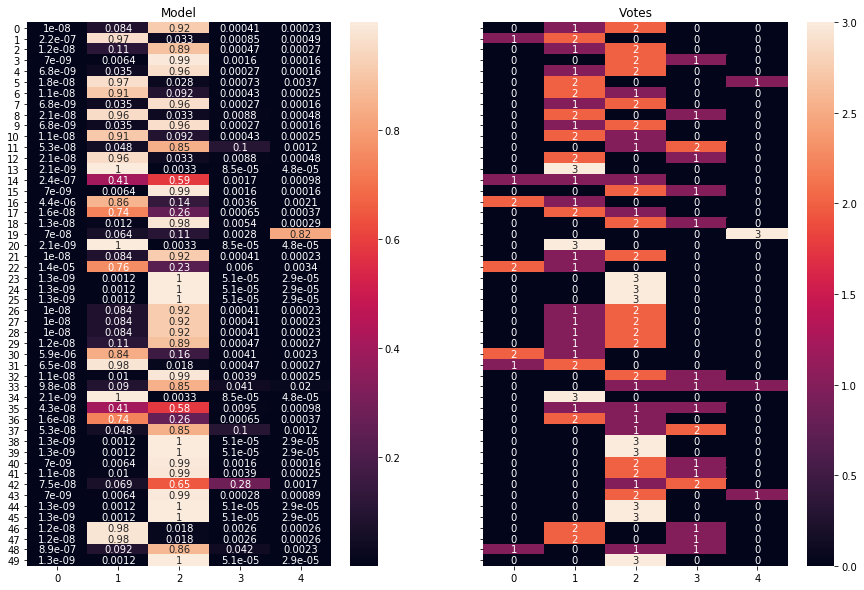

In [66]:
makeQuestionComparison(model, anno)

In [68]:
model = ModelBt.create_initial_state(5,3)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

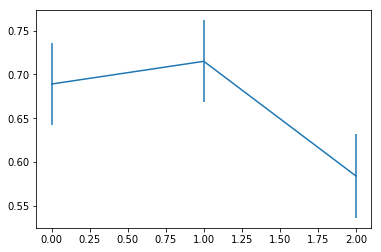

In [70]:
plt.figure()
plt.errorbar(range(3),y, yerr = y_ci)
plt.show()

According to the graph above, coder1 has the highest accuracy which code2 has the lowest accuracy. Code0 and coder1 are closer than their distance with coder2 respectively. This result is consistent with our findings above. Therefore, we can say that coder1 and coder0 are more reliable coder in this case. However, sample size with 3 coders is very small, so in order to increase th